#### Functions (IGNORE)

In [1]:
# import packages that will be used for analysis
import random

# set the random set
random.seed(4)
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

##### Get Stock Data
- Get data from start to end
- Download stock data for different periods
- Get adjusted sector ETF nd

In [2]:
import yfinance as yf
missing_data_tickers = [] # use this as a list of tickers with missing data

def get_data_from_start_to_end(ticker, start_date, end_date):
    global missing_data_tickers  # Use the global list to accumulate missing tickers
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        if stock_data.empty:
            missing_data_tickers.append(ticker)
            raise ValueError(f"Stock data for ticker {ticker} during the period from {start_date} to {end_date} was not found.")
        return stock_data
    except Exception as e:
        print(f"An error occurred for ticker {ticker}: {e}")
        missing_data_tickers.append(ticker)
        return None


In [3]:
# for a variety of periods load in different list of tickers
def download_stock_data_for_periods(tickers, periods):
    all_data = {}
    
    for period, (start_date, end_date) in periods.items():
        period_data = {}
        for ticker in tickers:
            data = get_data_from_start_to_end(ticker, start_date, end_date)
            if data is not None:
                period_data[ticker] = data
        all_data[period] = period_data
    
    return all_data

In [4]:
import pandas as pd

# Get the adjusted close prices
adj_close_sector_etf = {}

# Create adjusted close price only listing of sector ETFs
def get_adjusted_closed_price(nested_dict, tickers, periods):
    for period in periods:
        stock_price_df = pd.DataFrame()  # Create a new DataFrame for each period
        for ticker in tickers:
            stock_price_df[ticker] = nested_dict[period][ticker]['Adj Close']
        
        adj_close_sector_etf[period] = stock_price_df  # Store the complete DataFrame for the period
    
    return adj_close_sector_etf

##### Stochastic Modeling

In [5]:
def stochastic_roi(tickers,periods,return_rates_list,analysis_type):
    df = pd.DataFrame(index=tickers,columns=periods)
    for period in periods:
        for ticker in tickers:
            data = pd.Series(return_rates_list[period][ticker])
            if analysis_type=='Mean':
                df.at[ticker,period] = data.mean()
            elif analysis_type=='Median':
                df.at[ticker,period] = data.median()
            elif analysis_type=='Std':
                df.at[ticker,period] = data.std()
            elif analysis_type=='Variance':
                df.at[ticker,period] = data.var()

    return df

##### Bollinger Bands

In [6]:
# create bollinger bands
import scipy.stats as stats
def add_bollinger_data(data,window,conf_int):
        z_score = stats.norm.ppf(1 - (1 - conf_int) / 2) # create a zscore from the mean

        data['middle_band'] = data['Adj Close'].rolling(window).mean()
        data['upper_band'] = data['middle_band'] + z_score * data['Adj Close'].rolling(window).std()
        data['lower_band'] = data['middle_band'] - z_score * data['Adj Close'].rolling(window).std()

        data['Signal'] = 'Hold'

        data['Signal'] = np.where(data['Adj Close'] < data['lower_band'], 'Buy', 
                              np.where(data['Adj Close'] > data['upper_band'], 'Sell', 'Hold'))

        return data

In [7]:
# create bollinger data for multiple time period and multiple tickers
def bollinger_data_multiple_periods_tickers(periods,tickers,data,window,confidence_period):
    # for each ticker in economic time periods
    for period in periods:
            for ticker in tickers:
                    try:
                        add_bollinger_data(data[period][ticker],window,confidence_period)
                    except KeyError:
                        print(f'Data for {ticker} does not exist during {period}')
    return data

In [8]:
# create a function that plots the bollinger bands and actions
def plot_with_boll_bands(bollinger_data,title):
    """
    bollinger_data: holds the signals and bollinger data
    """
    buy_data = []
    sell_data = []

    for index, row in bollinger_data.iterrows():
        if row['Signal']=='Buy':
            buy_data.append(row['Adj Close'])
        else:
            buy_data.append(np.nan)

        if row['Signal'] == 'Sell':
            sell_data.append(row['Adj Close'])

        else:
            sell_data.append(np.nan)

    bollinger_data['Buy Data'] = buy_data
    bollinger_data['Sell Data'] = sell_data

    plt.figure(figsize=(12,8))
    
    plt.plot(bollinger_data.index,bollinger_data['Adj Close'],color='grey',label='Adjusted Close Price')
    plt.plot(bollinger_data.index,bollinger_data['lower_band'],color='green',label='Lower Band',linestyle='-')
    plt.plot(bollinger_data.index,bollinger_data['upper_band'],color='red',label='Upper Band',linestyle='-')
    plt.scatter(bollinger_data.index,bollinger_data['Buy Data'],marker='o',color='green',label='Buy Signal')
    plt.scatter(bollinger_data.index,bollinger_data['Sell Data'],marker='o',color='red',label='Sell Signal')

    #plt.plot(investment_tracking_df['Date'],investment_tracking_df['Investment Value'])
    # goal is to make a subplot which shows both the investment and bollinger bands

    plt.xlabel('Date')
    plt.xticks(rotation=60)
    plt.title(title)
    plt.ylabel('Price')
    plt.legend()
    plt.show()

##### Signals

In [9]:
def list_signals(stock_data_with_signals, tickers, periods):
    # Initialize a dictionary to store Buy/Sell signals
    signals_data = {period: {ticker: {'Buy': [], 'Sell': []} for ticker in tickers} for period in periods}

    for period in periods:
        for ticker in tickers:
            # Loop over rows in stock data for the specific period and ticker
            for idx, row in stock_data_with_signals[period][ticker].iterrows():
                if row['Signal'] == 'Buy':
                    # Append the index of the Buy signal
                    signals_data[period][ticker]['Buy'].append(pd.to_datetime(idx))
                elif row['Signal'] == 'Sell':
                    # Append the index of the Sell signal
                    signals_data[period][ticker]['Sell'].append(pd.to_datetime(idx))

    return signals_data

In [10]:
def collect_signals(nested_dict, periods, tickers):
    # Initialize an empty dictionary to hold DataFrames for each period
    bb_nested_dict = {}

    for period in periods:
        # Create a DataFrame for each period with the tickers as columns
        signals_period = pd.DataFrame(columns=tickers)
        
        # Loop through each ticker and extract the 'Signal'
        for ticker in tickers:
            signals_period[ticker] = nested_dict[period][ticker]['Signal']
        
        # Store the DataFrame in the dictionary using the period as the key
        bb_nested_dict[period] = signals_period

    # Return the dictionary containing DataFrames for each period
    return bb_nested_dict

##### Plot data

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot percentage-based histogram
def plot_percentage_histogram(data, title, xlabel, ylabel, bins=10, color='skyblue'):
    """
    Plots a percentage-based histogram for the given data.

    Parameters:
    data (array-like): Data to plot the histogram for.
    title (str): Title of the plot.
    xlabel (str): Label for the x-axis.
    ylabel (str): Label for the y-axis.
    bins (int): Number of bins for the histogram.
    color (str): Color for the histogram bars.
    """
    # Set modern aesthetic
    sns.set_style("whitegrid")

    # Create the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=bins, color=color, edgecolor='black',
             weights=np.ones_like(data) / len(data))

    # Convert y-axis to percentages
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))

    # Add titles and labels with improved font sizes
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    # Add gridlines for better readability
    plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

##### Stock Investment History

In [12]:
def stochastic_roi(tickers,periods,return_rates_list,analysis_type):
    df = pd.DataFrame(index=tickers,columns=periods)
    for period in periods:
        for ticker in tickers:
            data = pd.Series(return_rates_list[period][ticker])
            if analysis_type=='Mean':
                df.at[ticker,period] = data.mean()
            elif analysis_type=='Median':
                df.at[ticker,period] = data.median()
            elif analysis_type=='Std':
                df.at[ticker,period] = data.std()
            elif analysis_type=='Variance':
                df.at[ticker,period] = data.var()

    return df

In [13]:
from datetime import timedelta
import numpy as np
import pandas as pd

def zip_calculate_stock_roi(bb_signals_nd, adj_close_nd, periods_date, periods_list, tickers, n_sample, initial_investment, future_investments, percent_to_buy, percent_to_sell):
    # Initialize a nested dictionary to store ROI percentages for each period and ticker
    roi_results = {period: {ticker: [] for ticker in tickers} for period in periods_list}

    # Loop through each economic period
    for period in periods_list:
        # Create the date range for the current period
        date_range = pd.date_range(start=pd.to_datetime(periods_date[period][0]), end=pd.to_datetime(periods_date[period][1]) - timedelta(days=110))
        
        # Get random dates for stochastic modeling
        start_dates = np.random.choice(date_range, size=n_sample, replace=True)

        # Loop through sampled start dates
        for start_date in start_dates:
            time_stamp = pd.to_datetime(start_date)

            # Extract the adjusted close and signal data for time period
            adj_close_period = adj_close_nd[period].loc[time_stamp:time_stamp + timedelta(days=110)]
            bb_signals_period = bb_signals_nd[period].loc[time_stamp:time_stamp + timedelta(days=110)]

            # Initialize variables for each ticker
            account_balance = {ticker: future_investments for ticker in tickers}  # Separate account balance for each stock
            shares_number = {ticker: initial_investment/adj_close_period[ticker].iloc[0] for ticker in tickers}  # Initialize share count for each ticker
            shares_value = {ticker: initial_investment for ticker in tickers}   # Initialize share value for each ticker

            # Iterate over each day in the Bollinger Band signals and adjusted close prices
            for row_idx, (signals_row, adj_close_row) in enumerate(zip(bb_signals_period.iterrows(), adj_close_period.iterrows())):
                signals_row = signals_row[1]  # Extract the actual row (signals) - don't need the index
                adj_close_row = adj_close_row[1]  # Extract the actual row (adjusted close prices)

                # Now zip over the signal row and the corresponding adjusted close price for each ticker
                for ticker, (signal, adj_close_price) in zip(tickers, zip(signals_row, adj_close_row)):
                    
                    # Handle Buy action
                    if signal == 'Buy':
                        amount_to_buy = percent_to_buy * account_balance[ticker]
                        if account_balance[ticker] >= amount_to_buy:
                            shares_to_buy = amount_to_buy / adj_close_price
                            shares_number[ticker] += shares_to_buy
                            account_balance[ticker] -= amount_to_buy

                    # Handle Sell action
                    elif signal == 'Sell':
                        if shares_number[ticker] > 0:
                            shares_value[ticker] = shares_number[ticker] * adj_close_price
                            amount_to_sell = percent_to_sell * shares_value[ticker]
                            if shares_value[ticker] >= amount_to_sell:
                                shares_to_sell = amount_to_sell / adj_close_price
                                shares_number[ticker] -= shares_to_sell
                                account_balance[ticker] += amount_to_sell

            # Calculate total portfolio value for each stock at the end of the period
            for ticker in tickers:
                if shares_number[ticker] > 0:  # Only calculate value if shares are owned
                    portfolio_value = shares_number[ticker] * adj_close_period.iloc[-1][ticker]
                    total_value = account_balance[ticker] + portfolio_value
                    
                    # Calculate profit for this stock
                    profit = total_value - (initial_investment + future_investments)
                    
                    # Calculate ROI based on stock's individual account
                    roi_dollar_value = (profit / (initial_investment + future_investments)) * 100
                else:
                    roi_dollar_value = 0

                # Store ROI in the results dictionary
                roi_results[period][ticker].append(roi_dollar_value)

    return roi_results

In [14]:
def calculate_stock_roi_momentum_scale(bb_signals_nd, adj_close_nd, periods_date, periods_list, tickers, n_sample, initial_investment, percent_to_buy, percent_to_sell):
    # Initialize a nested dictionary to store ROI percentages for each period and ticker
    roi_results = {period: {ticker: [] for ticker in tickers} for period in periods_list}
    
    # Set a cap for the maximum scaling
    max_scaling_factor = 3
    
    # Loop through each economic period
    for period in periods_list:
        # Create the date range for the current period
        date_range = pd.date_range(start=pd.to_datetime(periods_date[period][0]), end=pd.to_datetime(periods_date[period][1]) - timedelta(days=110))
        
        # Get random dates for stochastic modeling
        start_dates = np.random.choice(date_range, size=n_sample, replace=True)

        # Loop through sampled start dates
        for start_date in start_dates:
            time_stamp = pd.to_datetime(start_date)

            # Initialize variables
            account_balance = {ticker: initial_investment for ticker in tickers}  # Separate account balance for each stock
            shares_number = {ticker: 0 for ticker in tickers}  # Initialize share count for each ticker
            consecutive_buy = 0
            consecutive_sell = 0

            # Extract the adjusted close and signal data for time period
            adj_close_period = adj_close_nd[period].loc[time_stamp:time_stamp + timedelta(days=110)]
            bb_signals_period = bb_signals_nd[period].loc[time_stamp:time_stamp + timedelta(days=110)]

            # Iterate over each row in the Bollinger Band signals (day by day)
            for row_idx, row in bb_signals_period.iterrows():
                for col_idx, signal in enumerate(row):
                    ticker = tickers[col_idx]  # Correctly get ticker for each column
                    adj_close_price = adj_close_period.loc[row_idx, ticker]  # Get corresponding adjusted close price

                    # Handle Buy action
                    if signal == 'Buy':
                        consecutive_buy += 1
                        consecutive_sell = 0
                        percent_to_buy_mod = min(percent_to_buy * (1 + consecutive_buy * 0.5), max_scaling_factor)
                        amount_to_buy = percent_to_buy_mod * account_balance[ticker]
                        if account_balance[ticker] >= amount_to_buy:
                            shares_to_buy = amount_to_buy / adj_close_price
                            shares_number[ticker] += shares_to_buy
                            account_balance[ticker] -= amount_to_buy

                    # Handle Sell action
                    elif signal == 'Sell':
                        consecutive_sell += 1
                        consecutive_buy = 0
                        percent_to_sell_mod = min(percent_to_sell * (1 + consecutive_sell * 0.5), max_scaling_factor)
                        if shares_number[ticker] > 0:
                            shares_to_sell = percent_to_sell_mod * shares_number[ticker]  # Sell a percentage of shares
                            if shares_number[ticker] >= shares_to_sell:
                                shares_number[ticker] -= shares_to_sell
                                account_balance[ticker] += shares_to_sell * adj_close_price  # Convert sold shares to cash

            # Calculate total portfolio value for each stock at the end of the period
            for ticker in tickers:
                if shares_number[ticker] > 0:  # Only calculate value if shares are owned
                    portfolio_value = shares_number[ticker] * adj_close_period.iloc[-1][ticker]
                    total_value = account_balance[ticker] + portfolio_value
                    
                    # Calculate profit for this stock
                    profit = total_value - initial_investment
                    
                    # Calculate ROI based on stock's individual account
                    roi_dollar_value = profit / initial_investment * 100
                else:
                    roi_dollar_value = 0

                # Store ROI in the results dictionary
                roi_results[period][ticker].append(roi_dollar_value)

    return roi_results

In [15]:
from datetime import timedelta
import numpy as np
import pandas as pd

def calculate_stock_roi_volatility(bb_signals_nd, adj_close_nd, periods_date, periods_list, tickers, n_sample, initial_investment, future_investments, percent_to_buy, percent_to_sell):
    # Initialize a nested dictionary to store ROI percentages for each period and ticker
    roi_results = {period: {ticker: [] for ticker in tickers} for period in periods_list}
    average_volatility = {period: {ticker: [] for ticker in tickers} for period in periods_list}

    # Loop through each economic period
    for period in periods_list:
        # Create the date range for the current period
        date_range = pd.date_range(start=pd.to_datetime(periods_date[period][0]), end=pd.to_datetime(periods_date[period][1]) - timedelta(days=110))
        
        # Get random dates for stochastic modeling
        start_dates = np.random.choice(date_range, size=n_sample, replace=True)

        # Loop through sampled start dates
        for start_date in start_dates:
            time_stamp = pd.to_datetime(start_date)

            # Extract the adjusted close and signal data for time period
            adj_close_period = adj_close_nd[period].loc[time_stamp:time_stamp + timedelta(days=110)]
            bb_signals_period = bb_signals_nd[period].loc[time_stamp:time_stamp + timedelta(days=110)]

            # Initialize variables
            account_balance = {ticker: future_investments for ticker in tickers}  # Separate account balance for each stock
            shares_number = {ticker: initial_investment / adj_close_period[ticker].iloc[0] for ticker in tickers}  # Initialize share count for each ticker
            shares_value = {ticker: initial_investment for ticker in tickers}   # Initialize share value for each ticker

            # Iterate over each row in the Bollinger Band signals (day by day)
            for row_idx, row in bb_signals_period.iterrows():
                for col_idx, signal in enumerate(row):
                    ticker = tickers[col_idx]  # Correctly get ticker for each column
                    adj_close_price = adj_close_period.loc[row_idx, ticker]  # Get corresponding adjusted close price

                    # Handle Buy action
                    if signal == 'Buy':
                        amount_to_buy = percent_to_buy * account_balance[ticker]
                        if account_balance[ticker] >= amount_to_buy:
                            shares_to_buy = amount_to_buy / adj_close_price
                            shares_number[ticker] += shares_to_buy
                            account_balance[ticker] -= amount_to_buy

                    # Handle Sell action
                    elif signal == 'Sell':
                        if shares_number[ticker] > 0:
                            shares_value[ticker] = shares_number[ticker] * adj_close_price
                            amount_to_sell = percent_to_sell * shares_value[ticker]
                            if shares_value[ticker] >= amount_to_sell:
                                shares_to_sell = amount_to_sell / adj_close_price
                                shares_number[ticker] -= shares_to_sell
                                account_balance[ticker] += amount_to_sell

            # Calculate total portfolio value for each stock at the end of the period
            for ticker in tickers:
                if shares_number[ticker] > 0:  # Only calculate value if shares are owned
                    portfolio_value = shares_number[ticker] * adj_close_period.iloc[-1][ticker]
                    total_value = account_balance[ticker] + portfolio_value
                    
                    # Calculate profit for this stock
                    profit = total_value - (initial_investment + future_investments)
                    
                    # Calculate ROI based on stock's individual account
                    roi_dollar_value = profit / (initial_investment + future_investments) * 100
                else:
                    roi_dollar_value = 0

                # Store ROI in the results dictionary
                roi_results[period][ticker].append(roi_dollar_value)

                # Calculate the standard deviation (volatility) for the adjusted close prices within this period
                volatility = adj_close_period[ticker].std()

                # Store volatility in the results dictionary
                average_volatility[period][ticker].append(volatility)

    return roi_results, average_volatility

In [16]:
def calculate_correlation(roi_results, average_volatility):
    # Create empty lists to store ROI and volatility data
    roi_values = []
    volatility_values = []
    
    # Iterate through periods and tickers to collect ROI and volatility data
    for period in roi_results:
        for ticker in roi_results[period]:
            # Collect ROI values and corresponding volatility values
            roi_values.extend(roi_results[period][ticker])  # Add ROI values
            volatility_values.extend(average_volatility[period][ticker])  # Add volatility values

    # Create a DataFrame to align the ROI and volatility
    data_df = pd.DataFrame({
        'ROI': roi_values,
        'Volatility': volatility_values
    })

    # Calculate Pearson correlation
    correlation = data_df.corr(method='pearson')

    # Calculate Spearman rank correlation (optional for non-linear relationships)
    spearman_corr = data_df.corr(method='spearman')
    
    return data_df,correlation, spearman_corr

##### Grid search optimization

In [17]:
# define the different parameters for rolling window and confidence interval
from itertools import product

# create a function that inputs conf interval and rolling average and return a roi

def grid_search_bollinger_bands(etf_data,adj_close_etf_data,param_grid,periods_list,periods_date,tickers,n_sample,initial_investment,future_investment,percent_to_buy,percent_to_sell):
     results =[]


     for rolling_window, confidence_interval in product(param_grid['rolling_windows'],param_grid['confidence_intervals']):

          # create bb signals for the different rolling window and confidence interval combination
          data_nd = bollinger_data_multiple_periods_tickers(periods_list,tickers,etf_data, rolling_window,confidence_interval)

          signals_nd = collect_signals(data_nd,periods_list,tickers)

          # calculate the roi for that combination
          roi_results = zip_calculate_stock_roi(signals_nd,adj_close_etf_data,periods_date,periods_list,tickers,n_sample,initial_investment,future_investment,percent_to_buy,percent_to_sell)

          # average the roi across all periods and tickers so there is a single value
          average_roi = np.mean([np.mean(roi_results[period][ticker]) for period in periods_list for ticker in tickers])

          # Append the result (rolling window, confidence interval, average ROI) to the list
          results.append({
          'rolling_window': rolling_window,
          'confidence_interval': confidence_interval,
          'average_roi': average_roi
     })

     # Convert the results list to a DataFrame
     roi_df = pd.DataFrame(results)
    
     return roi_df

In [48]:
import numpy as np
import pandas as pd
from itertools import product

def investment_amount_grid_search_bollinger_bands(etf_data, adj_close_etf_data, param_grid, periods_list, periods_date, tickers, n_sample, initial_investment,future_investment):
    results = []
    
    # Iterate over combinations of amount_to_buy and amount_to_sell
    for amount_to_buy, amount_to_sell in product(param_grid['amount_to_buy'], param_grid['amount_to_sell']):
        
        # Create Bollinger Bands signals for different rolling windows and confidence intervals
        data_nd = bollinger_data_multiple_periods_tickers(periods_list, tickers, etf_data, 30, 0.90)
        
        # Collect the signals for different periods and tickers
        signals_nd = collect_signals(data_nd, periods_list, tickers)
        
        # Calculate the ROI for each combination
        roi_results = zip_calculate_stock_roi(signals_nd, adj_close_etf_data, periods_date, periods_list, tickers, n_sample, initial_investment,future_investment, amount_to_buy, amount_to_sell)
        
        # Average the ROI across all periods and tickers so there is a single value
        average_roi = np.mean([np.mean(roi_results[period][ticker]) for period in periods_list for ticker in tickers])
        
        # Append the result (amount to buy, amount to sell, and average ROI) to the results list
        results.append({
            'amount_to_buy': amount_to_buy,
            'amount_to_sell': amount_to_sell,
            'average_roi': average_roi
        })
    
    # Convert the results list to a DataFrame
    roi_df = pd.DataFrame(results)
    
    return roi_df

# Chapter 2: Bollinger Bands
The Bollinger Bands Investment technique is a popular technical analysis tool created by John Bollinger in the 1980's. They measure market volatility and utilize moving averages to understand whether a stock is overbought (price is high) or oversold (price is low). This can be used to create buy and sell signals which can be used by themselves or a part of more elaborate trading techniques in which they give insight into the price of the stock. Bollinger Band technique creates the following parameters:
- Middle band: The 20 day moving average
- Upper band: The 20 day moving average plus 2 standard deviations of the current moving average
- Lower band: The 20 day moving average minus 2 standard deviations of the current moving average

## Bollinger Bands Strategy using Sector ETF's
Sector ETFs are the accumulation of a variety of stocks within one of the 11 GICS Sectors (see documentation). They are meant to be a representation of a sector's overall movement in the stock market. This will allow for a better understanding of which type of stocks based on their sectors perform best over time. To add further complexity, different economic time periods will be used to evaluate the changing success of an investment based on macroeconomic environments. For example some stocks out perform benchmarks during a recession due to their defensive nature such as the Health Care ETF (XLV).

Chapter 1 had investigated buy and hold strategies, this acted as a foundation for future investment strategies. Bollinger Bands in Chapter 2 are now going to be directly compared with buy and hold strategies.

## Sector ETF and Time Period Setup

In [19]:
# create time periods for where this takes place
economic_cycle_periods = {

    "trough": ("2008-10-01", "2009-06-01"),
    "expansion": ("2012-01-01", "2015-01-01"),
    "peak": ("2019-06-01", "2020-02-01"),
    "contraction": ("2007-12-01", "2008-10-01"),
    'all_data': ('2005-01-01','2024-06-01')
}

economic_cycle_periods_list = ['trough','expansion','peak','contraction','all_data']

In [20]:
# create etf tickers for sectors
sector_etf_tickers = [
    'XLB', # materials sector
    'XLI', # industrials sector
    'XLF', # financials
    'XLK', # information technology
    'XLY', # consumer discretionary
    'XLP', # consumer staples
    'XLE', # energy
    'XLV', # healthcare
    'VOX', # communication services
    'XLU', # utilities
    'IYR' # real estate
    ]

In [21]:
# save nested dictionary data as a variable to be accessed.
sector_etf_data = download_stock_data_for_periods(sector_etf_tickers,economic_cycle_periods)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

## Bollinger Bands
Bollinger bands require the use of the adjusted close price to create an upper and lower bound from the moving average. Working within the 'sector_etf_data' nested dictionary, the upper, middle and lower bound can be added as columns to the dataframe. This can then create a signal for each day which is going to be combined into one dataframe dependent on the macroeconomic cycle of investment.

In [22]:
# use 20 day moving average
# use a 95% confidence interval (2 standard deviations)
sector_etf_data = bollinger_data_multiple_periods_tickers(economic_cycle_periods_list,sector_etf_tickers,sector_etf_data,20,0.95)

In [23]:
# show an example of XLV healthcare sector during a trough
sector_etf_data['trough']['XLV']

,Open,High,Low,Close,Adj Close,Volume,middle_band,upper_band,lower_band,Signal
Date,,,,,,,,,,
2008-10-01,30.100000,30.480000,30.100000,30.250000,22.927485,6053600,NaN,NaN,NaN,Hold
2008-10-02,30.250000,30.590000,29.930000,30.299999,22.965389,6353400,NaN,NaN,NaN,Hold
2008-10-03,30.600000,30.600000,29.650000,29.650000,22.472725,6814400,NaN,NaN,NaN,Hold
2008-10-06,29.400000,29.879999,27.410000,28.540001,21.631414,8545000,NaN,NaN,NaN,Hold
2008-10-07,28.719999,28.780001,27.389999,27.850000,21.108444,5060200,NaN,NaN,NaN,Hold
...,...,...,...,...,...,...,...,...,...,...
2009-05-22,25.280001,25.400000,25.070000,25.290001,19.404520,3655700,19.163589,20.034961,18.292217,Hold
2009-05-26,25.190001,25.660000,24.889999,25.520000,19.580986,4412900,19.221135,20.041098,18.401172,Hold
2009-05-27,25.549999,25.600000,25.219999,25.260000,19.381493,4591100,19.265253,20.016433,18.514073,Hold


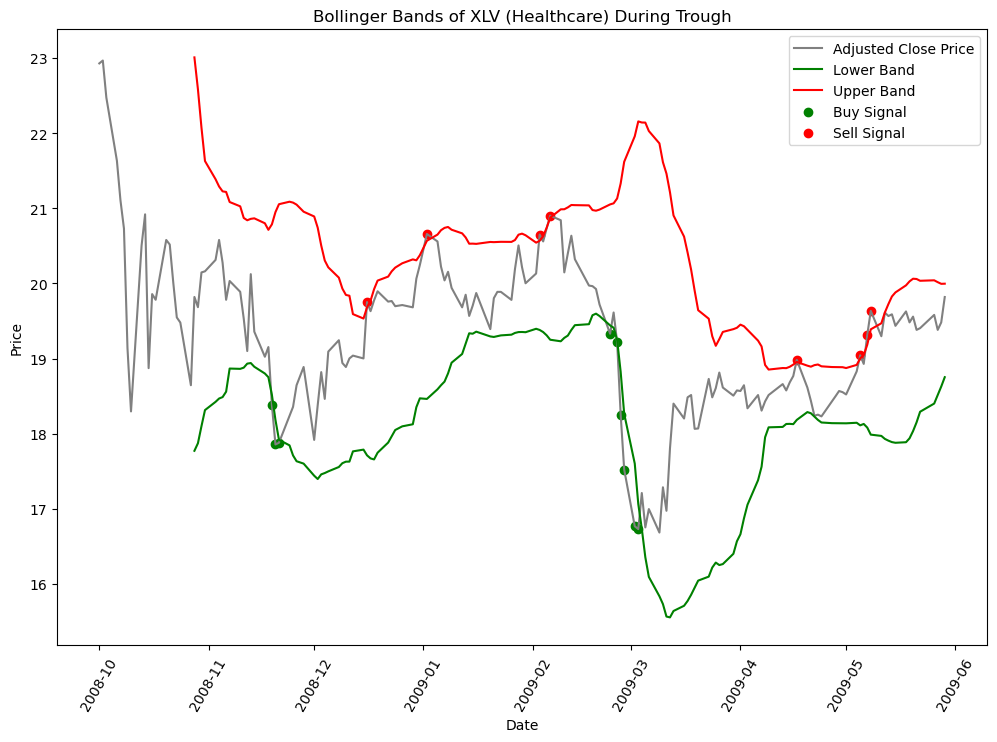

In [24]:
# show the same example but with bollinger bands plotted for XLV during trough
plot_with_boll_bands(sector_etf_data['trough']['XLV'],'Bollinger Bands of XLV (Healthcare) During Trough')

In [25]:
# observe the dates for the buy and sell signals as seen in the graph
signals_list = list_signals(sector_etf_data,sector_etf_tickers,economic_cycle_periods_list)
signals_list['trough']['XLV']

{'Buy': [Timestamp('2008-11-19 00:00:00'),
  Timestamp('2008-11-20 00:00:00'),
  Timestamp('2008-11-21 00:00:00'),
  Timestamp('2009-02-23 00:00:00'),
  Timestamp('2009-02-25 00:00:00'),
  Timestamp('2009-02-26 00:00:00'),
  Timestamp('2009-02-27 00:00:00'),
  Timestamp('2009-03-02 00:00:00'),
  Timestamp('2009-03-03 00:00:00')],
 'Sell': [Timestamp('2008-12-16 00:00:00'),
  Timestamp('2009-01-02 00:00:00'),
  Timestamp('2009-02-03 00:00:00'),
  Timestamp('2009-02-06 00:00:00'),
  Timestamp('2009-04-17 00:00:00'),
  Timestamp('2009-05-05 00:00:00'),
  Timestamp('2009-05-07 00:00:00'),
  Timestamp('2009-05-08 00:00:00')]}

This graph shows the movement of the healthcare sector ETF (XLV) during a trough. The buy signals are bought when the stock is locally moving down where as the stock is sold when the stock is moving up locally. There are 9 buy signals and 8 sell signals.

## Stochastic Modeling for Bollinger Bands
To understand Bollinger Bands it is important to test how they perform on return on investments during different periods. Not just once as there is lot of deviation for expected return, it is best to repeat the investment a number of times during the same periods using the same sector ETFs this is so you can get a broader understanding of the probability of a specific return on investment occurring.

Parameters
Investment period: 90 days
Collect sector ETF closing price
Collect signals for sector ETF

There will be n random samples of start dates from the macroeconomic cycle which will then perform the Bollinger Band investment strategy for 90 days and return the investment n times to understand the distribution function of returns.

In [26]:
# get the adjusted close price dataframe
sector_etf_closed_price = get_adjusted_closed_price(sector_etf_data,sector_etf_tickers,economic_cycle_periods_list)

In [27]:
# load in the dataframe for the trough time period
sector_etf_closed_price['trough']

,XLB,XLI,XLF,XLK,XLY,XLP,XLE,XLV,VOX,XLU,IYR
Date,,,,,,,,,,,
2008-10-01,23.119267,21.858328,12.413447,15.649679,22.589588,18.009502,37.393238,22.927485,36.648037,18.666506,34.011742
2008-10-02,21.458340,20.549883,11.794882,15.037062,21.771835,17.782770,35.261116,22.965389,35.561855,18.395723,31.759153
2008-10-03,21.247202,20.222771,11.278402,14.822245,21.010748,17.640251,34.840702,22.472725,35.039398,18.119318,30.064156
2008-10-06,20.198570,19.692125,10.689858,14.002766,20.419691,17.128466,32.966831,21.631414,33.396389,17.233658,29.512159
2008-10-07,19.156967,19.037905,9.560816,13.286713,19.108047,16.584295,31.159027,21.108444,31.966497,16.528519,27.019814
...,...,...,...,...,...,...,...,...,...,...,...
2009-05-22,18.848709,16.073528,7.178290,13.618084,18.520380,15.070187,29.497356,19.404520,33.037399,14.918155,18.541611
2009-05-26,19.300224,16.658968,7.412231,13.971803,19.143744,15.260789,30.122385,19.580986,34.221878,15.351322,19.500566
2009-05-27,18.576376,16.117992,7.190602,13.835140,18.725445,14.873018,29.794699,19.381493,33.881416,15.039447,18.851521


In [28]:
# get the signals for tickers
bb_signals = collect_signals(sector_etf_data,economic_cycle_periods_list,sector_etf_tickers)
bb_signals['trough'].iloc[20:40]

,XLB,XLI,XLF,XLK,XLY,XLP,XLE,XLV,VOX,XLU,IYR
Date,,,,,,,,,,,
2008-10-29,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold
2008-10-30,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold
2008-10-31,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold
2008-11-03,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold
2008-11-04,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold
2008-11-05,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold
2008-11-06,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold
2008-11-07,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold
2008-11-10,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold


Observe that there are some days where most etfs will suggest a buy such as 2008-11-20 where each stock indicated a buy signal. Each period has a sheet of actions where nan is a hold signal.

### Base Model
- 20 day period 
- 2 standard deviations
- 20% of balance buy amount
- 20% of shares number sell amount

In [29]:
# stochastic model 1000 times with a $100 investment of the stock
base_bb_average_return = zip_calculate_stock_roi(bb_signals,adj_close_sector_etf,economic_cycle_periods,economic_cycle_periods_list,sector_etf_tickers,1000,0,100,0.20,0.20)

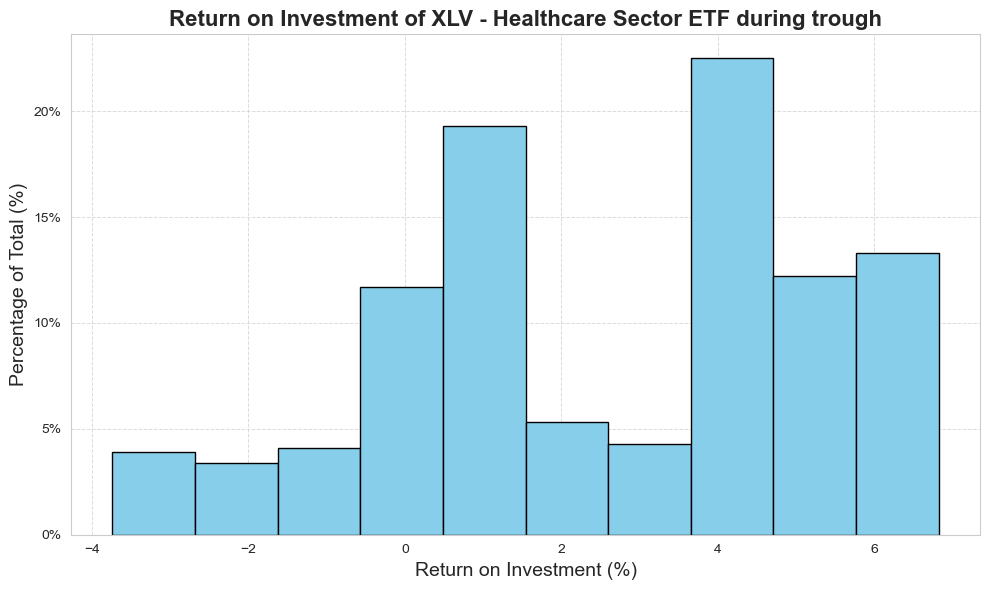

In [38]:
# plot the histogram of the XLV healthcare during a trough
plot_percentage_histogram(
    data=base_bb_average_return['trough']['XLV'],
    title=f'Return on Investment of XLV - Healthcare Sector ETF during trough',
    xlabel='Return on Investment (%)',
        ylabel='Percentage of Total (%)'
)

The distribution of XLV during a trough does not have any clear pattern. Unlike the buy and hold strategy which showed a relatively normally distributed graoh for each sector etf, it does not seem to be the case for bollinger bands. As there are only a certain number of buy and sell signals within the short time span of trough even though there are 1000 iterations of the process, it is not being tested on a large variety of buy and sell signals.

In [31]:
# get the mean of each stock during each time period
bollinger_band_average_return = stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,base_bb_average_return,'Mean')
bollinger_band_average_return

,trough,expansion,peak,contraction,all_data
XLB,6.807349,1.805238,3.630742,0.99736,0.884482
XLI,5.419597,2.332614,3.435631,-0.311274,1.016077
XLF,2.708618,2.204638,5.466416,-0.745932,0.878064
XLK,3.495412,1.971391,2.767455,-1.050287,1.513706
XLY,7.713906,2.200634,2.346197,1.652067,1.213958
XLP,1.996478,1.934816,1.027777,1.114767,1.145882
XLE,4.966485,1.259816,1.945478,1.492067,1.295343
XLV,2.658797,2.362427,2.156393,-0.25846,1.311049
VOX,8.449133,1.382008,2.674667,-1.559259,1.111322
XLU,-0.672033,0.995934,1.210235,-1.447831,0.955


In [40]:
stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,base_bb_average_return,'Std')

,trough,expansion,peak,contraction,all_data
XLB,5.244623,2.205494,1.624647,6.515423,5.335716
XLI,7.245873,2.370314,1.566602,3.464375,4.71549
XLF,20.029771,2.091217,2.497968,5.372086,5.220518
XLK,0.849111,2.389479,1.429841,2.533411,4.311605
XLY,3.986817,1.889154,0.726331,2.457889,4.525511
XLP,3.082573,1.990815,1.070094,1.186186,2.247343
XLE,3.57724,3.486201,1.560577,8.371762,6.598836
XLV,2.663305,2.215328,1.308603,2.024812,3.062997
VOX,4.362537,1.549181,1.393591,3.651589,3.827719
XLU,3.105537,1.588059,1.229146,3.186029,3.018608


In [32]:
bollinger_band_average_return.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Financial Capstone Project/data/performance_data/bollinger_band/base_model_bollinger_bands.csv')

There is both a large difference in stocks during different time periods and sectors within the same time period. For example if you look at a contraction while there is a 2.5% increase in 90 days for real estate, there is a 1.5% decrease in communication services and utilities.

In [33]:
bollinger_band_average_return.mean()

trough         4.094636
expansion      1.760517
peak           2.511454
contraction    0.254018
all_data       1.123324
dtype: float64

By averaging returns you get a good understanding of which time period the investment period works best. Even though a peak or an expansion you would expect to be the highest return such as when using a buy and hold strategy, the trough period actually showed the highest return. This is likely due to the higher volatility which allows for bollinger bands to find more time short time highs and lows, where as long term expansions do not create as many buy signals to keep up with the upward pressure on the sell signals.

In [34]:
# save file
bollinger_band_average_return.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Financial Capstone Project/data/bollinger_band_return.csv')

#### Machine Learning Optimization Model
Bollinger bands are made up of two parameters. The rolling average and confidence interval (stadard deviation). These two have a dynamic relationship with one another with their overall impact on the return on investment changing drastically depending on these values. The base model was one where John Bollinger encouraged a 20 day investment period with a 2 standard deviaiton which equates to about 95% confidence interval. This is going to be further investigated using hyperparameter tuning which will test the combination of different discrete sets of values to maximize returns. 

#### Hyperparameter Tuning
Using a list of discrete values for the rolling windows and confidence interval, a grid search can be done to find the optimal values for the maximum return on investment.

In [39]:

# create the dictionary for rolling windows and confidence intervals
param_grid = {
    'rolling_windows':[10,15,20,25,30],# this is the rolling average it requires n days before an investment can be made
    'confidence_intervals':[0.85,0.90,0.95]
}

# perform the grid search funciton which is going to brute force test each combination of rolling windows and confidence intervals
grid_search_bollinger_bands = grid_search_bollinger_bands(sector_etf_data,sector_etf_closed_price,param_grid,economic_cycle_periods_list,economic_cycle_periods,sector_etf_tickers,1000,0,100,0.20,0.2)

In [41]:
# list the results of the hyperparameter tuning based on the average ROI across the sector etfs across each period
grid_search_bollinger_bands.sort_values(by='average_roi',ascending=False)

,rolling_window,confidence_interval,average_roi
13,30,0.90,2.300693
10,25,0.90,2.257736
14,30,0.95,2.217719
7,20,0.90,2.208454
9,25,0.85,2.154662
4,15,0.90,2.128723
3,15,0.85,2.048683
11,25,0.95,2.019316
8,20,0.95,1.992208
1,10,0.90,1.965046


#### Optimized Bollinger Bands Model
By using grid search using the parameters, there has different combinations trialed 1000 times for each period and each ticker this is quite a lot of processing. The most optimal Bollinger Band during these time periods would be the following:
- rolling_window = 30
- confidence_interval = 0.90

The same process as done in the base model is going to performed with the optimized parameters.

In [42]:
# create relevant bollinger band signals
optimized_sector_etf_data = bollinger_data_multiple_periods_tickers(economic_cycle_periods_list,sector_etf_tickers,sector_etf_data,30,0.90)

# obtain the signals for tickers in periods
optimized_signals = collect_signals(optimized_sector_etf_data,economic_cycle_periods_list,sector_etf_tickers)

# get the average return across different stochastic modeling
optimizied_bb_average_return = zip_calculate_stock_roi(optimized_signals,adj_close_sector_etf,economic_cycle_periods,economic_cycle_periods_list,sector_etf_tickers,1000,0,100,0.20,0.20)

# return the average return
optimized_average_returns = stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,optimizied_bb_average_return,'Mean')

# display the dataframe
optimized_average_returns

,trough,expansion,peak,contraction,all_data
XLB,7.753349,2.379854,3.059695,1.480586,1.421559
XLI,3.916172,2.831595,2.486749,-0.461026,1.428412
XLF,4.899856,2.958349,2.603937,-2.89401,1.020666
XLK,9.651101,1.775291,2.287314,-0.244593,1.794671
XLY,10.418301,2.833845,2.525524,1.692315,1.433755
XLP,0.517179,2.032211,0.618319,1.998157,1.438623
XLE,6.415488,0.847087,2.341416,-1.191574,1.198993
XLV,5.006139,2.236567,2.725806,-0.014215,1.394241
VOX,11.24597,2.138,2.828805,-0.788491,1.354852
XLU,-0.060677,1.173006,1.778982,-1.299662,1.333643


In [43]:
# save the data as a csv
optimized_average_returns.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Financial Capstone Project/data/performance_data/bollinger_band/optimized_bollinger_bands.csv')

In [44]:
# average the return for the different sector etfs during the different periods
optimized_average_returns.mean()

trough         6.120023
expansion      2.030983
peak           2.214309
contraction    0.111721
all_data       1.355170
dtype: float64

Observe that the return for expansion, peak and contraction is about the same but it performs even better during a trough, with an average 7% return during a 90 day trough period, with some sectors going to returns as high as 10%. 

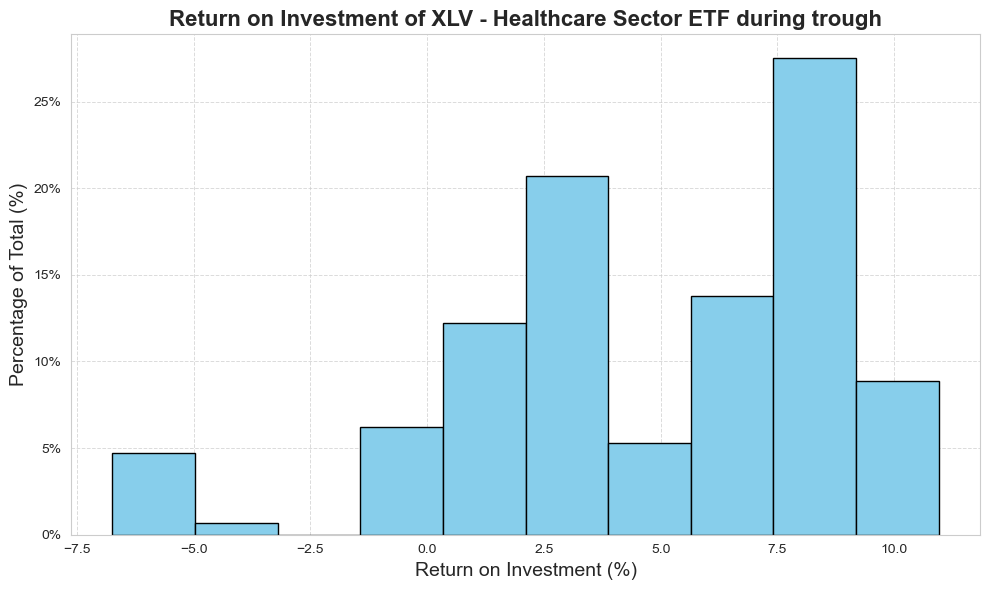

In [ ]:
# plot the histogram of the XLV healthcare during a trough
plot_percentage_histogram(
    data=optimizied_bb_average_return['trough']['XLV'],
    title=f'Return on Investment of XLV - Healthcare Sector ETF during trough',
    xlabel='Return on Investment (%)',
        ylabel='Percentage of Total (%)'
)

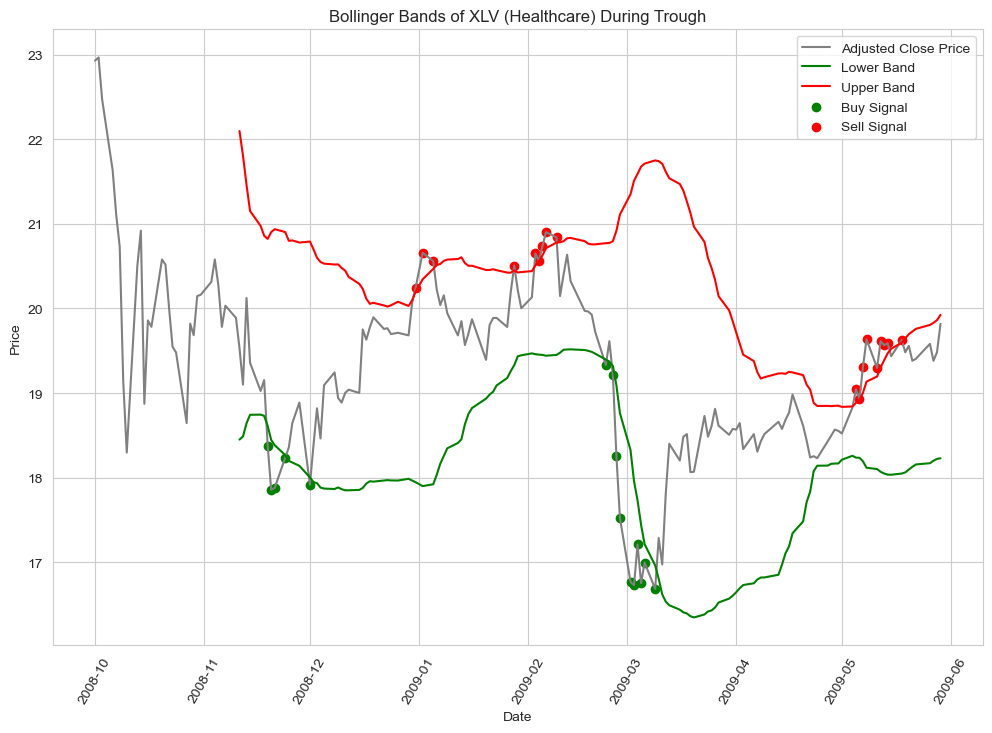

In [ ]:
# show the same example but with bollinger bands plotted for XLV during trough
plot_with_boll_bands(optimized_sector_etf_data['trough']['XLV'],'Bollinger Bands of XLV (Healthcare) During Trough')

Observe that with this parameter set for bollinger bands there are more signals of buying and selling but it takes longer for the investments to start to create the rolling average period. 

### Evaluation Against Benchmarks
The objective of technical analysis strategies is to outperform passive buy and hold strategies which are used by most investors. The next component of analysis is going to be a comparison to the performance against the benchmark buy and hold strategy.

In [ ]:
# import buy and hold data
benchmark_buy_hold = pd.read_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Financial Capstone Project/data/performance_data/buy_hold/buy_hold_average_return.csv')
benchmark_buy_hold.set_index('Unnamed: 0', inplace=True)
benchmark_buy_hold.index.name=None
benchmark_buy_hold = benchmark_buy_hold.iloc[:-1]
benchmark_buy_hold

,trough,expansion,peak,contraction,all_data
XLB,-0.761102,5.102247,4.030053,-0.193635,3.797282
XLI,-13.100481,6.555045,6.812673,-4.437122,4.243955
XLF,-21.387769,7.261487,9.528559,-15.437855,2.943663
XLK,3.476109,5.550516,12.595861,-2.618855,5.780237
XLY,-1.010424,6.998606,3.410997,-4.190119,4.535713
XLP,-8.075991,5.886525,5.153585,0.541664,3.508757
XLE,-4.847986,3.897256,-0.459049,3.632434,3.843197
XLV,-4.737405,9.125331,8.439893,-3.604999,4.093249
VOX,4.156066,5.633226,6.113023,-5.187206,3.427454
XLU,-8.918489,5.194923,6.308867,-2.484529,3.232738


#### Performance against base model

In [ ]:
# compare the performance
base_model_performance_against_benchmark_return = bollinger_band_average_return - benchmark_buy_hold
base_model_performance_against_benchmark_return

,trough,expansion,peak,contraction,all_data
IYR,NaN,NaN,NaN,NaN,NaN
VOX,3.204064,-4.523782,-4.357748,3.87079,-2.56773
XLB,6.761077,-3.591863,-1.54497,0.983958,-2.904836
XLE,9.13641,-3.057595,1.728946,-2.904329,-2.955705
XLF,24.048857,-5.316729,-5.908825,16.147545,-2.016935
XLI,17.883673,-4.538183,-4.385124,4.585118,-3.348693
XLK,-0.539303,-3.833421,-10.70481,1.748396,-4.673026
XLP,9.942465,-4.324492,-4.26456,0.24719,-2.474074
XLU,8.603081,-4.487526,-5.347985,1.00296,-2.426726
XLV,7.405775,-7.037122,-7.101651,3.305279,-3.063095


In [ ]:
# compare the performance
base_model_performance_against_benchmark_return.mean()

trough         9.392981
expansion     -4.590176
peak          -4.339804
contraction    3.468023
all_data      -2.988939
dtype: float64

The bollinger bands massively outperform against the trough and contraction passive buy and hold strategies. This is an important factor, it seems that when the economy has higher rates of return the bollinger bands are not as successful, overall you can see that there is a 2-3% worst performance than a typical buy and hold strategy. This is important for next stages of investigation where it might be neccessary to use bollinger bands during periods of higher volatility.

#### Performance against optimized model
The optimized model showed strong performance against the base model especially during the trough periods so it is likely to perform even better against the benchmark.

In [ ]:
optimized_model_performance_against_benchmark_return = optimized_average_returns - benchmark_buy_hold
optimized_model_performance_against_benchmark_return

,trough,expansion,peak,contraction,all_data
IYR,NaN,NaN,NaN,NaN,NaN
VOX,6.101819,-4.008579,-3.999013,3.794341,-2.229839
XLB,8.318724,-3.266054,-1.747164,1.263832,-2.553634
XLE,10.451071,-3.429043,2.169307,-4.876596,-2.896006
XLF,28.725603,-5.068894,-7.536392,13.871204,-1.611821
XLI,18.141408,-4.326391,-4.884302,4.219623,-2.990237
XLK,5.050321,-4.177572,-10.804336,2.093457,-4.294505
XLP,9.214631,-4.443853,-4.630541,1.01752,-2.382869
XLU,9.431527,-4.346978,-4.769892,0.824478,-2.254473
XLV,9.389788,-7.37721,-6.634829,3.314706,-2.865268


In [ ]:
# get the mean of each period
optimized_model_performance_against_benchmark_return.mean()

trough         11.636032
expansion      -4.530973
peak           -4.405728
contraction     3.135640
all_data       -2.721305
dtype: float64

It performs 10-14% better during a trough and overall you can see in some industries such as Finance it performs 30% better than a traditional buy and hold strategy. It is clear that the performance during peak and expansion periods (where economic activity is higher) the technical analysis strategy cannot keep up with the performance of the overall market.

### How to improve the performance of bollinger bands?
It is clear that during these periods of stronger economic growth the stocks do not perform as well in comparison to a buy and hold strategy which sees an average return of about 1.5% where as bollinger bands actually lose money. It is likely that the number of sell signals outweigh the number of buy signals which means that the stock investment does not have time to continue to improve.

#### Looking at bollinger bands returns

In [ ]:
# get the bollinger band of average return
bollinger_band_average_return[['expansion','peak']]

,expansion,peak
XLB,1.510385,2.485083
XLI,2.016863,2.427548
XLF,1.944758,3.619734
XLK,1.717095,1.891051
XLY,1.807557,1.899688
XLP,1.562034,0.889025
XLE,0.839661,1.269897
XLV,2.088209,1.338242
VOX,1.109444,1.755275
XLU,0.707397,0.960882


The return during a 90 day period does not go above a 1.7% when during a period of expansion you could see a return like this within a week, so the bollinger bands need to improve during this time period.

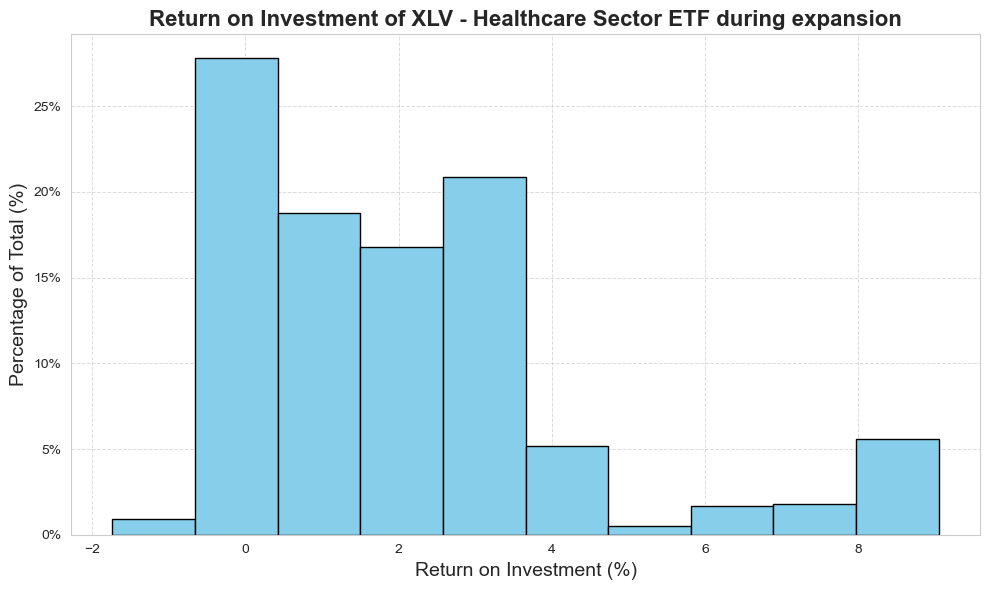

In [ ]:
# plot the histogram of the XLV healthcare during an expansion
plot_percentage_histogram(
    data=base_bb_average_return['expansion']['XLV'],
    title=f'Return on Investment of XLV - Healthcare Sector ETF during expansion',
    xlabel='Return on Investment (%)',
        ylabel='Percentage of Total (%)'
)

When you look at the distribution function for returns you can see that about 25-30% of returns are 0 this means that there is not enough investment that is going on.

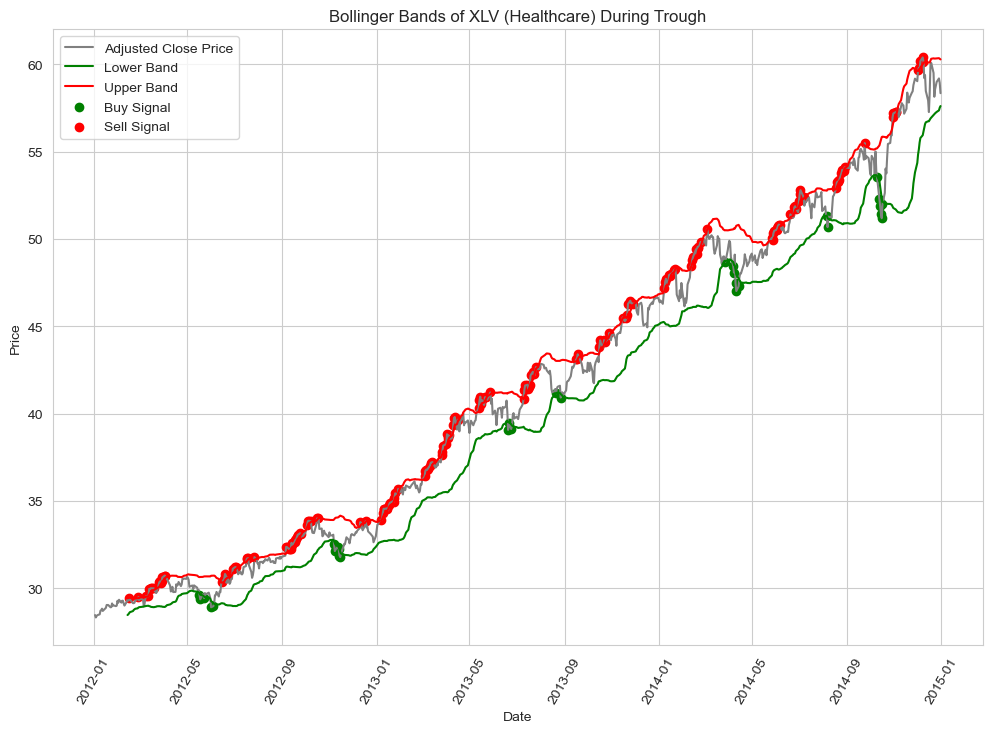

In [ ]:
# show the same example but with bollinger bands plotted for XLV during trough
plot_with_boll_bands(sector_etf_data['expansion']['XLV'],'Bollinger Bands of XLV (Healthcare) During Trough')

When there are more sell signals that buy signals when the investment cost is equal this means that there is not enough available funds to purchase, an investigation needs to be done into seeing the return on investment when different buy and sell of balance/share value returns.

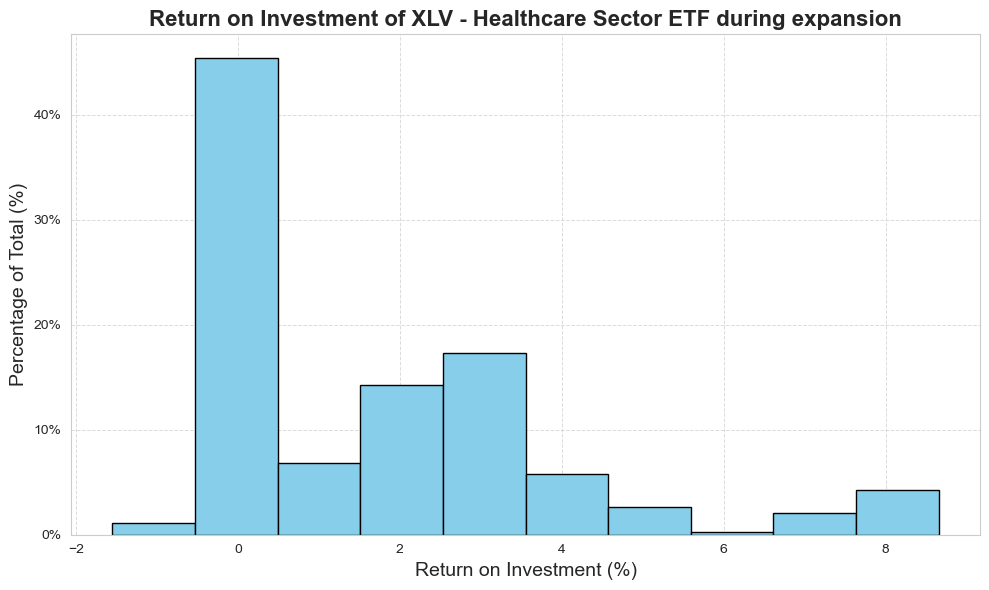

In [ ]:
# plot the histogram of the XLV healthcare during an expansion
plot_percentage_histogram(
    data=optimizied_bb_average_return['expansion']['XLV'],
    title=f'Return on Investment of XLV - Healthcare Sector ETF during expansion',
    xlabel='Return on Investment (%)',
        ylabel='Percentage of Total (%)'
)

During an expansion almost 50% does not return any value at the end, this is because all of the stocks have been sold. 

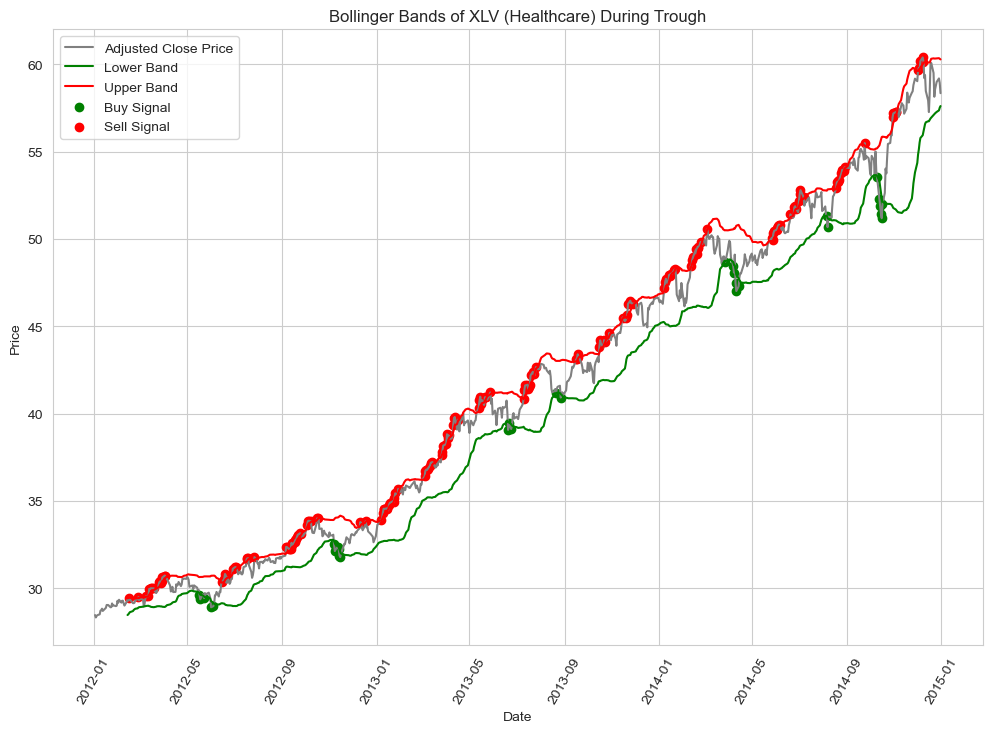

In [ ]:
plot_with_boll_bands(optimized_sector_etf_data['expansion']['XLV'],'Bollinger Bands of XLV (Healthcare) During Trough')

In [ ]:
# look at the buy/sell signals
list_signals_expansion_xlv = list_signals(sector_etf_data,sector_etf_tickers,economic_cycle_periods_list)['expansion']['XLV']

In [ ]:
buy_signals = len(list_signals_expansion_xlv['Buy'])
sell_signals = len(list_signals_expansion_xlv['Sell'])

print(f'The number of buy signals are {buy_signals}')
print(f'The number of sell signals are {sell_signals}')

The number of buy signals are 31
The number of sell signals are 176


There are even more sell signals as the confidence interval has been decreased to 90%. It is clear that during time periods of growth where the number of sell signals heavily outweigh the number of buy signals there is not enough time for the investments to acrude the increase that is observed in a buy and hold strategy. 

### Price Investment Optimized Model
As seen above it is clear that during different time periods there are far more sell signals such as expansion and trough compared to buy signals. It is possible that by testing different combinations of parameter optimization you might be able to find a better investment rate such as a higher buy percentage amount and a lower sell percentage amount.

In [49]:
# get the parameter options as a dictionary with lists for percentage amount to buy and percentage amount to sell
param_grid_price = {
    'amount_to_buy': [0.10, 0.20, 0.25, 0.30],
    'amount_to_sell': [0.10, 0.20, 0.25, 0.30]
}

# Call the function
roi_df = investment_amount_grid_search_bollinger_bands(
    sector_etf_data, 
    sector_etf_closed_price, 
    param_grid_price, 
    economic_cycle_periods_list, 
    economic_cycle_periods, 
    sector_etf_tickers, 
    1000,
    100,
    0
)

In [66]:
roi_df.sort_values(by='average_roi',ascending=False)

,amount_to_buy,amount_to_sell,average_roi
8,0.25,0.10,1.011124
14,0.30,0.25,0.974791
7,0.20,0.30,0.941745
12,0.30,0.10,0.941131
3,0.10,0.30,0.936773
4,0.20,0.10,0.909636
15,0.30,0.30,0.907081
6,0.20,0.25,0.902382
2,0.10,0.25,0.885098
9,0.25,0.20,0.860593


In [65]:
invest_optimizied_bb_average_return = zip_calculate_stock_roi(bb_signals,adj_close_sector_etf,economic_cycle_periods,economic_cycle_periods_list,sector_etf_tickers,1000,0,100,0.25,0.10)
invest_optimized_average_returns = stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,invest_optimizied_bb_average_return,'Mean')
invest_optimized_average_returns

,trough,expansion,peak,contraction,all_data
XLB,7.765887,2.142579,4.150888,0.899567,1.315584
XLI,4.46483,2.853828,4.117309,-0.506847,1.483233
XLF,0.283859,2.677466,6.456746,-1.646791,1.305553
XLK,4.230295,2.344611,3.693765,-1.290774,1.875441
XLY,8.69132,2.455414,2.578699,1.646444,1.668344
XLP,1.571762,2.34406,1.268152,1.252529,1.597865
XLE,5.299421,1.655926,1.880704,2.024374,1.465924
XLV,2.783723,2.817683,2.868914,-0.189,1.581485
VOX,9.190425,1.707008,3.256173,-1.827652,1.34835
XLU,-0.846359,1.124955,1.48774,-1.607149,1.090927


In [69]:
invest_optimized_average_returns.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Financial Capstone Project/data/performance_data/bollinger_band/invest_optimized_average_returns.csv')

In [56]:
invest_optimized_average_returns.mean()

trough         6.120023
expansion      2.030983
peak           2.214309
contraction    0.111721
all_data       1.355170
dtype: float64

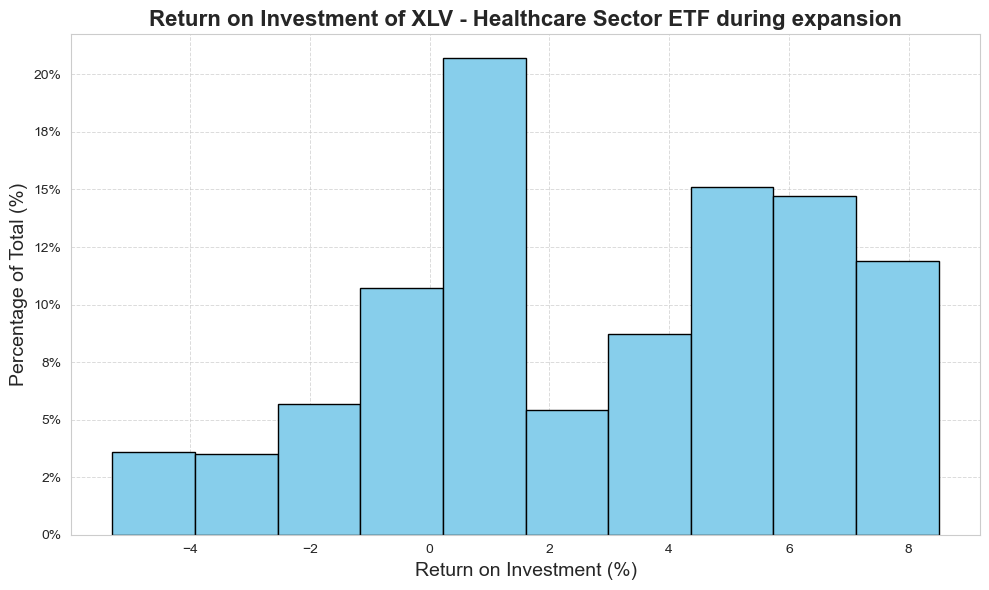

In [63]:
# plot the histogram of the XLV healthcare during an expansion
plot_percentage_histogram(
    data=invest_optimizied_bb_average_return['trough']['XLV'],
    title=f'Return on Investment of XLV - Healthcare Sector ETF during expansion',
    xlabel='Return on Investment (%)',
        ylabel='Percentage of Total (%)'
)

### Buy and Hold with Bollinger Bands
As seen from exploring the Bollinger Band technique above, when the number of sell signals heavily outweights the number of buy signals, there are not enough opportunities for the stocks to continue to grow. Another approach that is going to be taken is by holding $50 of initial investment in the stock as well as $50 to be used to invest in the stocks.

In [89]:
buy_hold_bb_list_returns = zip_calculate_stock_roi(bb_signals,sector_etf_closed_price,economic_cycle_periods,economic_cycle_periods_list,sector_etf_tickers,1000,50,50,0.20,0.20)

In [92]:
initial_future_bb_return = stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,buy_hold_bb_list_returns,'Mean')
initial_future_bb_return

,trough,expansion,peak,contraction,all_data
XLB,2.381273,2.599061,4.307817,0.793593,2.105379
XLI,1.311176,3.507798,4.667287,-2.370513,2.23647
XLF,-8.346266,3.673334,6.857565,-6.387975,1.80764
XLK,3.69922,3.055357,5.27589,-1.620679,2.686236
XLY,5.381706,3.655086,3.112744,-0.394344,2.306436
XLP,-0.521206,2.919771,2.611191,0.970686,1.984889
XLE,2.283772,1.729359,1.739661,2.334975,2.10501
XLV,1.295779,3.965332,3.75659,-2.021946,2.12914
VOX,6.428731,2.546961,4.00209,-2.613043,1.596614
XLU,-2.631432,2.078569,2.591666,-2.208553,1.809815


In [93]:
initial_future_bb_return.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Financial Capstone Project/data/performance_data/bollinger_band/buy_hold_bollinger.csv')

In [91]:
initial_future_bb_return.mean()

trough         0.370515
expansion      2.858190
peak           3.768622
contraction   -1.091393
all_data       2.047033
dtype: float64

### How does Volatility impact the performance of Bollinger Bands?
The goal of this next part is to investigate how different volatility levels during a 90 day investment period are going to compare to the roi of the investment period. This is going to be done across all data from 2005 to 2024-06-01.

From the investigation it is likely that whenever there is a period of high volatility the effectiveness of bollinger bands increase. One way to improve the performance of the model overall is to understand the relationship between volatility bollinger band ROI.

In [94]:
average_return, average_volatility = calculate_stock_roi_volatility(optimized_signals,adj_close_sector_etf,economic_cycle_periods,['all_data'],sector_etf_tickers,1000,0,100,0.2,0.2)

In [95]:
# Example usage
data,correlation, spearman_corr = calculate_correlation(average_return, average_volatility)

# Display the results
print("Pearson Correlation:\n", correlation)
print("Spearman Correlation:\n", spearman_corr)

Pearson Correlation:
                  ROI  Volatility
ROI         1.000000   -0.172226
Volatility -0.172226    1.000000
Spearman Correlation:
                  ROI  Volatility
ROI         1.000000   -0.060921
Volatility -0.060921    1.000000


The impact of volatility on ROI is low. This means that looking at how much the data varies over a given time period is not something that needs to be considered when making a model.

### Conclusion
The best performing model is the optimzed 90% confidence interval and with a 30 day rolling average.